<a href="https://colab.research.google.com/github/NathanLabiosa/MonkeyEmotionClassifier/blob/main/Monkey_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

''

In [ ]:
from google.colab import drive
import os
import shutil 
drive.flush_and_unmount()
drive.mount('/content/drive', force_remount=True)

# feel free to edit this cell to work with your local or colab directory
WORKING_DIR = '/content/drive/My Drive/Colab Notebooks/monkey'
TRAIN_DIR = '/content/drive/My Drive/Colab Notebooks/monkey/train'
VAL_DIR = '/content/drive/My Drive/Colab Notebooks/monkey/val'

shutil.move(os.path.join(WORKING_DIR,'ImageData','sad_chimp'), os.path.join(TRAIN_DIR))
shutil.move(os.path.join(WORKING_DIR,'ImageData','angry_chimp'), os.path.join(TRAIN_DIR))
shutil.move(os.path.join(WORKING_DIR,'ImageData','excited_chimp'), os.path.join(TRAIN_DIR))
shutil.move(os.path.join(WORKING_DIR,'ImageData','sleeping_chimp'), os.path.join(TRAIN_DIR))
#os.rmdir(os.path.join(WORKING_DIR,'ImageData'))

Mounted at /content/drive


'/content/drive/My Drive/Colab Notebooks/monkey/train/sleeping_chimp'

In [ ]:
from glob import glob

from sklearn.model_selection import train_test_split

angry = glob(TRAIN_DIR + '/angry_chimp/*.jpg')
sad = glob(TRAIN_DIR + '/sad_chimp/*.jpg')
excited = glob(TRAIN_DIR + '/excited_chimp/*.jpg')
sleeping = glob(TRAIN_DIR + '/sleeping_chimp/*.jpg')

# The *_val variables contain the filenames of the files chosen for validation. 
angry_train, angry_val = train_test_split(angry, test_size=0.3)
sad_train, sad_val = train_test_split(sad, test_size=0.3)
excited_train, excited_val = train_test_split(excited, test_size=0.3)
sleeping_train, sleeping_val = train_test_split(sleeping, test_size=0.3)


# This code moves the validation files out of the train directory and over to 
# the val directory.
os.makedirs(os.path.join(VAL_DIR,'angry_chimp'))
for file in angry_val:
  os.rename(file, file.replace('train','val'))

os.makedirs(os.path.join(VAL_DIR,'sad_chimp'))
for file in sad_val:
  os.rename(file, file.replace('train','val'))

os.makedirs(os.path.join(VAL_DIR,'excited_chimp'))
for file in excited_val:
  os.rename(file, file.replace('train','val'))

os.makedirs(os.path.join(VAL_DIR,'sleeping_chimp'))
for file in sleeping_val:
  os.rename(file, file.replace('train','val'))

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet_v2 import preprocess_input

WIDTH = 299
HEIGHT = 299
BATCH_SIZE = 11

# data prep
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=90,
    zoom_range=[1,2],
    horizontal_flip=True,
    fill_mode='nearest')

validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=90,
    zoom_range=[1,2],
    horizontal_flip=True,
    fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(HEIGHT, WIDTH),
		batch_size=BATCH_SIZE,
		class_mode='categorical')
    
validation_generator = validation_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(HEIGHT, WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical')

Found 107 images belonging to 4 classes.
Found 48 images belonging to 4 classes.


In [ ]:
from keras.models import Model
from tensorflow.keras.applications.resnet_v2 import ResNet152V2

base_model = ResNet152V2(weights='imagenet', include_top=False)

234561536/234545216 [==============================] - 2s 0us/step


In [ ]:
from keras.layers import Dense, GlobalAveragePooling2D, Dropout


CLASSES = 4
# These layers were removed by setting include_top=false, but we still want them
x = base_model.output                          # The output layer of the googleNet
x = GlobalAveragePooling2D(name='avg_pool')(x) # This layer is used to downsample the features
x = Dropout(0.4)(x)                            # This layer is used to enforce feature redundancy 

# This layer specifies our classifier output
predictions = Dense(CLASSES, activation='softmax')(x)
#
model = Model(inputs=base_model.input, outputs=predictions)



In [ ]:
for layer in base_model.layers:
    layer.trainable = False # Set this to True if you want to re-train the entire network.

In [ ]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
EPOCHS = 30
BATCH_SIZE = 11
STEPS_PER_EPOCH = 5
VALIDATION_STEPS = 1
MODEL_FILE = os.path.join(WORKING_DIR,'model_ex')

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=validation_generator,
    validation_steps=VALIDATION_STEPS)
  
model.save(MODEL_FILE)

Epoch 1/30
5/5 [==============================] - 66s 12s/step - loss: 1.7165 - accuracy: 0.2727 - val_loss: 1.5797 - val_accuracy: 0.3636
Epoch 2/30
5/5 [==============================] - 50s 10s/step - loss: 1.7290 - accuracy: 0.2364 - val_loss: 1.6513 - val_accuracy: 0.2727
Epoch 3/30
5/5 [==============================] - 50s 10s/step - loss: 1.5705 - accuracy: 0.3091 - val_loss: 1.1708 - val_accuracy: 0.4545
Epoch 4/30
5/5 [==============================] - 48s 10s/step - loss: 1.4972 - accuracy: 0.3846 - val_loss: 1.0492 - val_accuracy: 0.6364
Epoch 5/30
5/5 [==============================] - 48s 10s/step - loss: 1.5347 - accuracy: 0.3269 - val_loss: 1.3993 - val_accuracy: 0.3636
Epoch 6/30
5/5 [==============================] - 50s 10s/step - loss: 1.3480 - accuracy: 0.4182 - val_loss: 1.5935 - val_accuracy: 0.3636
Epoch 7/30
5/5 [==============================] - 48s 10s/step - loss: 1.3752 - accuracy: 0.4808 - val_loss: 1.1060 - val_accuracy: 0.4545
Epoch 8/30
5/5 [===========

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


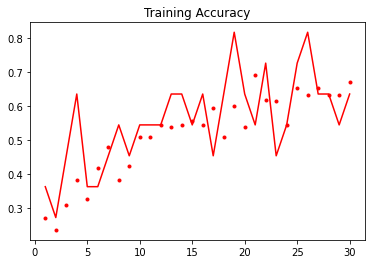

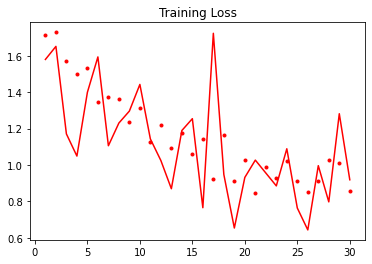

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
epochs = range(1,len(acc)+1)

plt.plot(epochs, val_acc,'r')
plt.plot(epochs, acc,'r.')
plt.title("Training Accuracy")

plt.figure()
plt.plot(epochs, val_loss,'r')
plt.plot(epochs,loss,'r.')
plt.title("Training Loss")
plt.show()

In [ ]:
print('Validation Accuracy at Final Epoch =', val_acc[-1])
print(val_acc)

Validation Accuracy at Final Epoch = 0.5454545617103577
[0.27272728085517883, 0.27272728085517883, 0.27272728085517883, 0.3636363744735718, 0.3636363744735718, 0.5454545617103577, 0.5454545617103577, 0.3636363744735718, 0.1818181872367859, 0.4545454680919647, 0.27272728085517883, 0.5454545617103577, 0.4545454680919647, 0.5454545617103577, 0.4545454680919647, 0.7272727489471436, 0.4545454680919647, 0.5454545617103577, 0.3636363744735718, 0.5454545617103577, 0.3636363744735718, 0.4545454680919647, 0.3636363744735718, 0.7272727489471436, 0.4545454680919647, 0.5454545617103577, 0.7272727489471436, 0.7272727489471436, 0.7272727489471436, 0.5454545617103577]


Mounted at /content/drive


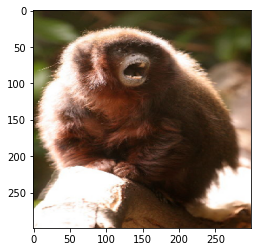

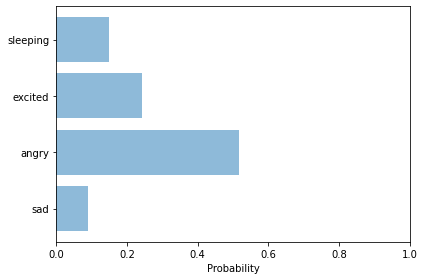

In [ ]:
import numpy as np
from keras.preprocessing import image
from keras.models import load_model
drive.flush_and_unmount()
drive.mount('/content/drive', force_remount=True)

# Predict pre-processes the input so that it matches the format expected by the 
# network, then runs model.predict which provides the class predictions
def predict(model, img):
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    preds = model.predict(x)
    return preds[0]

# We plot the original image
plt.figure()
img = image.load_img('/content/drive/My Drive/Colab Notebooks/monkey/test/test2.jpg', target_size=(HEIGHT, WIDTH))
preds = predict(load_model(MODEL_FILE), img)
plt.imshow(img)

# We can visualize the predicted likelihood of each class
plt.figure()
labels = ["sad", "angry","excited","sleeping"]
plt.barh(range(4),preds,alpha=0.5)
plt.yticks(range(4),labels)
plt.xlabel('Probability')
plt.xlim(0,1)
plt.tight_layout()
plt.show()

Mounted at /content/drive


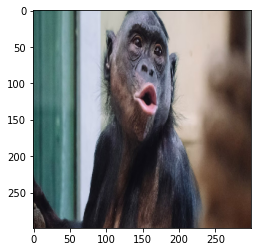

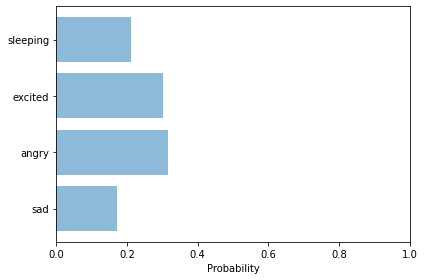

In [ ]:
import numpy as np
from keras.preprocessing import image
from keras.models import load_model
drive.flush_and_unmount()
drive.mount('/content/drive', force_remount=True)

# Predict pre-processes the input so that it matches the format expected by the 
# network, then runs model.predict which provides the class predictions
def predict(model, img):
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    preds = model.predict(x)
    return preds[0]

# We plot the original image
plt.figure()
img = image.load_img('/content/drive/My Drive/Colab Notebooks/monkey/test/test5.jpg', target_size=(HEIGHT, WIDTH))
preds = predict(load_model(MODEL_FILE), img)
plt.imshow(img)

# We can visualize the predicted likelihood of each class
plt.figure()
labels = ["sad", "angry","excited","sleeping"]
plt.barh(range(4),preds,alpha=0.5)
plt.yticks(range(4),labels)
plt.xlabel('Probability')
plt.xlim(0,1)
plt.tight_layout()
plt.show()